<a href="https://colab.research.google.com/github/vijaylokith/Topic-Modelling/blob/master/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TOPIC MODELLING: LDA(Latent Dirichlet Allocation)**

In [4]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from gensim.models import CoherenceModel

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Topic Modelling/20_newsgroup.csv")
df.columns = ["number", "text", "target", "title", "date"]
df.head()

,number,text,target,title,date
0,0,I was wondering if anyone out there could enli...,7,rec.autos,2022-08-02 13:48:37.251043
1,17,I recently posted an article asking what kind ...,7,rec.autos,2022-08-02 13:48:37.251043
2,29,\nIt depends on your priorities. A lot of peo...,7,rec.autos,2022-08-02 13:48:37.251043
3,56,an excellent automatic can be found in the sub...,7,rec.autos,2022-08-02 13:48:37.251043
4,64,: Ford and his automobile. I need information...,7,rec.autos,2022-08-02 13:48:37.251043


As we are only doing topic modelling anything other than the text will not be usefull. So we will remove it.

In [8]:
df = df.drop(columns = ["number", "title", "target","date"], axis=1)
df.head()

,text
0,I was wondering if anyone out there could enli...
1,I recently posted an article asking what kind ...
2,\nIt depends on your priorities. A lot of peo...
3,an excellent automatic can be found in the sub...
4,: Ford and his automobile. I need information...


In [9]:
df.shape

(11314, 1)

Now as we readed our data, now it is time for data cleaning and pre-processing.
As a part this process we will be:

> We will be performing Tokenization.

> We will be removing all the stopwords in english.

> Then we will perform stemming and lemmatization.



> Before performing the above steps we should first check for null values and remove them else we will get a error while pre-processing, as np.nan are typed as float and all out pre-processing will only work on str type.



In [10]:
df['text'].isnull().values.sum()

218

In [11]:
df['text'] = df['text'].fillna('').astype(str)

In [12]:
print(df['text'].isnull().values.sum())
df.head()

0


,text
0,I was wondering if anyone out there could enli...
1,I recently posted an article asking what kind ...
2,\nIt depends on your priorities. A lot of peo...
3,an excellent automatic can be found in the sub...
4,: Ford and his automobile. I need information...


In [13]:
stemmer = SnowballStemmer('english')
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]
pd.DataFrame(data = {'original word': original_words, 'stemmed': singles})



,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [14]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [15]:
processed_df = df["text"].map(preprocess)

In [16]:
processed_df[:5]

0    [wonder, enlighten, door, sport, look, late, e...
1    [recent, post, articl, ask, kind, rat, singl, ...
2    [depend, prioriti, peopl, higher, prioriti, mi...
3    [excel, automat, subaru, legaci, switch, sport...
4    [ford, automobil, need, inform, ford, partial,...
Name: text, dtype: object

> Now our data is almost ready for modelling, but as a final step we should convert this text's into vectors as machine learning models cannot process text.

> For that cause BoW will be used to featurize the text data.(uni-gram as mentioned in the assignment)

In [17]:
dictionary = gensim.corpora.Dictionary(processed_df)

In [18]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_df]
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 2),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 2),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 1)]

> As we have converted our text data in to vector, now we can create a base model which we will acting as a benchmark.

In [19]:
base_lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, random_state=100,chunksize=100,passes=10,per_word_topics=True)

> Let's measure the performence of our model(metric used is "Coherence Score").

In [20]:
coherence_model_lda = CoherenceModel(model=base_lda_model, texts=processed_df, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4179196460500879


Hyperparameter Tuning...

Before performing hyperparameter tuning it is important to know what are the parameters which drive the model. So basically this model has 1 hyper-parameter and 2 normal parameters.

> Hyper-Parameter: K -> num_topics(number of topics).

LDA by default it cannot find the optimal number of topics to be derived from the given data. Hence it is our responsebility to deal with it.

> Parameters: α -> Document-Topic Density;  β -> Word-Topic Density.

A low value of alpha will assign fewer topics to each document whereas a high value of alpha will have the opposite effect. A low value of beta will use fewer words to model a topic whereas a high value will use more words.

> We will just be tuning k (number of topics) as it is the most important parameter which has a high impact in the models performance. 

In [21]:
# k value ranges from 1 to 15
num_topics = list(range(1,16))

lda_models = {}

for i in num_topics:
  lda_models[i] = gensim.models.LdaMulticore(bow_corpus, num_topics=i, id2word=dictionary, random_state=100,chunksize=100,passes=10,per_word_topics=True)

In [22]:
hyper_para_coherence = [CoherenceModel(model=lda_models[i], texts=processed_df, dictionary=dictionary, coherence='c_v').get_coherence() for i in num_topics]

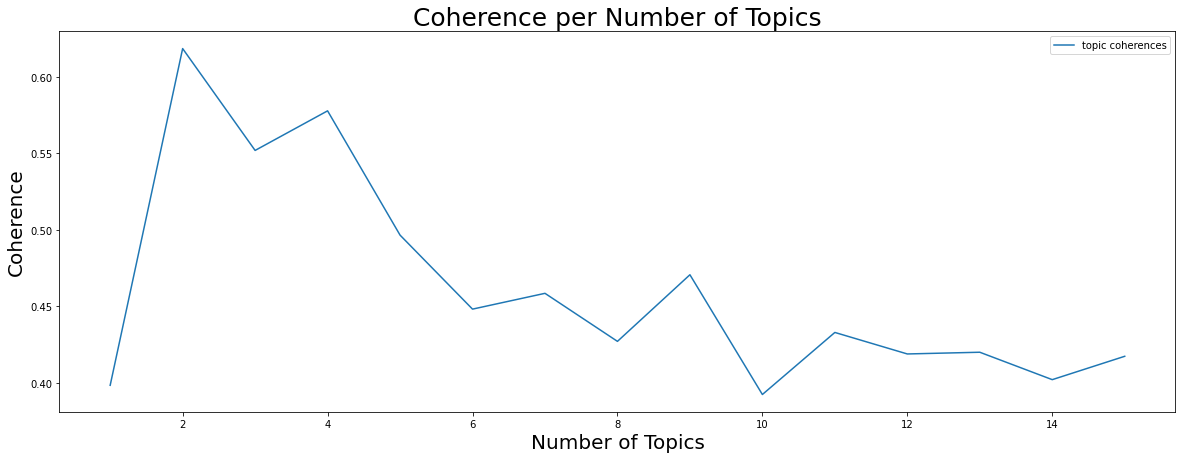

In [30]:
plt.figure(figsize=(20,7))
ax= sns.lineplot(x=num_topics, y=hyper_para_coherence, label="topic coherences")
ax.axes.set_title('Coherence per Number of Topics', fontsize=25)
ax.set_ylabel('Coherence', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.show() 

It is clear that for 2 topics the model has the highest coherence value.

In [26]:
final_model = lda_models[2]

print(CoherenceModel(model=final_model, texts=processed_df, dictionary=dictionary, coherence='c_v').get_coherence())

0.6183616717914828


> By tuning the k(number of topics) we almost got a coherent score which yeild over 49% when compared to the baseline model. 

In [27]:
print("These are the topics and their corresponding weights associated with the keywords")
for idx, topic in final_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

These are the topics and their corresponding weights associated with the keywords
Topic: 0 
Words: 0.018*"encrypt" + 0.012*"chip" + 0.008*"key" + 0.007*"inform" + 0.007*"secur" + 0.007*"number" + 0.007*"privaci" + 0.006*"program" + 0.006*"anonym" + 0.006*"public"
Topic: 1 
Words: 0.010*"peopl" + 0.007*"know" + 0.007*"think" + 0.007*"govern" + 0.006*"say" + 0.006*"right" + 0.006*"like" + 0.005*"go" + 0.005*"time" + 0.004*"come"
